In [1]:
#!rm *.nc*

# Sentinel-6 MF L2 Altimetry: OPeNDAP Access and Gridding

In this tutorial you will learn how to access variable subsets from OPeNDAP in the Cloud.

## Requirements

This workflow was developed using Python 3.9 (and tested against versions 3.7, 3.8). The [`pyresample`](https://pyresample.readthedocs.io/en/latest/installation.html) package is the only remaining dependency besides common packages like `numpy` and `xarray`. You may uncomment the first line of the following cell to install *pyresample*, if necessary. Then, import all the required Python packages.

In [2]:
#!python -m pip install numpy pyresample xarray
import os
import tqdm
import requests
import numpy as np
import pandas as pd
import xarray as xr
import pyresample as pr
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from pyresample.kd_tree import resample_gauss
from io import StringIO

cmr = "cmr.earthdata.nasa.gov"

def get_collection(url: str=f"https://{cmr}/search/collections.umm_json", **params):
    return requests.get(url, params).json().get("items")[0]
        
def get_opendap(record: dict):
    for url in record.get("RelatedUrls"):
        if 'opendap.earthdata.nasa.gov' in url.get("URL"):
            return url.get("URL")

def get_granules(ShortName: str, provider: str="POCLOUD", page_size: int=200, **kwargs):
    url = f"https://{cmr}/search/granules.umm_json"
    params = dict(ShortName=ShortName, provider="POCLOUD", page_size=page_size)
    granules = pd.DataFrame(requests.get(url, {**params,**kwargs}).json().get("items"))
    granules['GranuleUR'] = granules.umm.apply(lambda x: x.get("GranuleUR"))
    granules['OPeNDAP'] = granules.umm.apply(get_opendap)
    coverage = granules.umm.apply(lambda x: x.get("TemporalExtent").get("RangeDateTime").values()).apply(list)
    granules['Start'] = coverage.apply(sorted).apply(lambda x: x[0])
    granules['End'] = coverage.apply(sorted).apply(lambda x: x[1])
    return granules

## Dataset

### About the mission

This demo uses data acquired by the Sentinel-6A Michael Freilich (S6A) satellite altimetry mission, which provides precise measurements of ocean surface height. It is the latest iteration in a series of missions, which together provide an uninterupted sea surface height record going back more than 30 years.

Satellite altimetry is a precise science carried out by [Ocean Surface Topography](#Ocean-Surface-Topography) researchers through the Jason-series radar altimetry missions. Instrument specifications, operational procedures, data calibration and analysis are sometimes referred to colloquially as "along-track altimetry" (a term that I find useful to understanding the data provided at level 2, like in the dataset we use here).

Learn more through resources linked in the [Appendix]([#Sentinel-6A-MF)).

### About the data

In a nutshell:

* **What?** calibrated sea surface height measurements,
* **Where?** from -66.0 to 66.0 degrees latitude, 
* **When?** beginning in June 2021,
* **How?** global coverage acquired every 10 days (1 cycle of 128 orbits)


<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F.jpg" width="80%">

<i>Figure: depicted data structure for level-2 along-track altimetry datasets from Sentinel-6A</i>

PO.DAAC typically refers to datasets by their *ShortName*: ***JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F***. The *ShortName* contains the following info for all Sentinel-6 datasets at level 2: 

* **JASON_CS:** referring to Jason Continuity of Service (Jason-CS), the mission series/instrument class;
* **S6A:** referring to Sentinel-6A (instead of Sentinel-6B, which is expected to launch in 2025);
* **L2:** Level 2, the data processing level;
* **ALT:** Altimetry, the data product type and application;
* **LR:** Low Resolution, versus High Resolution (HR);
* **RED:** Reduced, the smaller of two datasets distributed at Level 2 (the other being *Standard*, which contains more variables)
* **OST:** Ocean Surface Topography, the science domain/team/community;
* **NRT:** Near Real Time, the data latency; i.e. accessible within 3 hours (vs. STC or NTC; lower latencies)

## Discovery

The unique 'concept-id' assigned to each PO.DAAC dataset, or 'collection', within the Earthdata system is functionally the same as the ShortName in the context of PO.DAAC's collections in the cloud (because we also assign unique ShortNames). This cell is downloading metadata to retrieve that identifier from an external source, then download metadata about the series of files that make up the time series for the cycle specified by the variable 'cycle', and merging to table. 

### Search for files/granules

Pick any cycle after cycle 25, which was around the time of the first release of data from S6A. (This cell calls three functions defined in the cell above.)

In [3]:
cycle = 25

name = "JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F"

concept_id = get_collection(ShortName=name).get("meta").get("concept-id")

granules = get_granules(name, cycle=cycle)  

granules[['GranuleUR', 'Start', 'End']].set_index("GranuleUR")

,Start,End
GranuleUR,,
S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02,2021-07-13T16:26:44.514Z,2021-07-13T18:22:34.471Z
S6A_P4_2__LR_RED__NR_025_003_20210713T182234_20210713T201839_F02,2021-07-13T18:22:34.522Z,2021-07-13T20:18:39.482Z
S6A_P4_2__LR_RED__NR_025_006_20210713T201839_20210713T215450_F02,2021-07-13T20:18:39.532Z,2021-07-13T21:54:50.473Z
S6A_P4_2__LR_RED__NR_025_007_20210713T215450_20210713T234732_F02,2021-07-13T21:54:50.523Z,2021-07-13T23:47:32.482Z
S6A_P4_2__LR_RED__NR_025_009_20210713T234732_20210714T014224_F02,2021-07-13T23:47:32.533Z,2021-07-14T01:42:24.454Z
...,...,...
S6A_P4_2__LR_RED__NR_025_245_20210723T050533_20210723T064603_F02,2021-07-23T05:05:33.543Z,2021-07-23T06:46:03.471Z
S6A_P4_2__LR_RED__NR_025_247_20210723T064603_20210723T083817_F02,2021-07-23T06:46:03.521Z,2021-07-23T08:38:17.483Z
S6A_P4_2__LR_RED__NR_025_249_20210723T083817_20210723T103256_F02,2021-07-23T08:38:17.533Z,2021-07-23T10:32:56.490Z


## Access

These functions have nothing to do with Earthdata or PO.DAAC services, all Python 3 standard library except for tqdm and wget:

In [4]:
def download(source: str):
    target = os.path.basename(source.split("?")[0])
    if not os.path.isfile(target):
        !wget --quiet --continue --output-document $target $source
    return target

def download_all(urls: list, max_workers: int=12):
    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        workers = pool.map(download, urls)
        return list(tqdm.tqdm(workers, total=len(urls)))

### Explore dataset variables

The S6A level 2 altimetry datasets include variables for sea surface height anomaly (SSHA), significant wave height (SWH), wind speed, others.

In [5]:
opendap_url = f"https://opendap.earthdata.nasa.gov/collections/{concept_id}"

urls = granules.GranuleUR.apply(lambda f: f"{opendap_url}/granules/{f}.nc4")
                                
urls.iloc[0].replace(".nc4", ".html")

'https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.html'

### Get subsets from OPeNDAP

Prepare the full request urls by adding a comma-delimited list of variables, after the question mark `?`.

In [6]:
variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']

query = ",".join(variables)

reqs = urls.apply(lambda x: f"{x}?{query}")

print(reqs.iloc[0])

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha


The function(s) below download granules from a remote `source` to a local `target` file, and reliably manage simultaneous streaming downloads divided between multiple threads.

In [7]:
files = download_all(urls=reqs, max_workers=12)

100%|██████████| 125/125 [00:53<00:00,  2.32it/s]


In [8]:
!du -sh .

16M	.


**Why this way?**

To be explained...

**Will it scale?**

The source netcdf files range from 2500KB to 3000KB per file. The OPeNDAP subsets that we just downloaded are around 100KB a pop. It took less than 10 minutes to download the same subsets for ~1700 files, that covers a period of roughly  You can extrapolate to a reasonable estimate for time series of any length (even the whole mission).

Total size of the source data is ~4.25GB, based on:

```
2500KB x 1700 = 4250000KB (4250 megabytes)
```

versus, total size of the subset time series:

```
100KB  x 1700 =  17000KB  (170 megabytes)
```

Plot it to put this in context, because our goal is to produce one global grid for the entire cycle of data that we just downloaded.

### Open, plot ssh time series

Sort the list of subset files to ensure they concatenate in proper order. Call `open_mfdataset` on the list to open all the subsets in memory as one dataset in xarray.

In [9]:
ds = xr.open_mfdataset(sorted(files), engine="netcdf4")

print(ds)

<xarray.Dataset>
Dimensions:            (data_01_time: 827001)
Coordinates:
  * data_01_time       (data_01_time) datetime64[ns] 2021-07-13T16:26:45 ... ...
Data variables:
    data_01_longitude  (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    data_01_latitude   (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    data_01_ku_ssha    (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
Attributes: (12/63)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4___

Two prerequisites to plot based on personal preference:

1. rename all the variables to drop the group names (because I just think they're too long as is)
2. get a tuple with two timestamps for the start and end of the time series coverage for the cycle

Plot the cycle as a series on a geographic plot, which should look just like the one at the top of this notebook:

Text(0.5, 1.0, "ssha for cycle 25 (('2021-07-13', '2021-07-23'))")

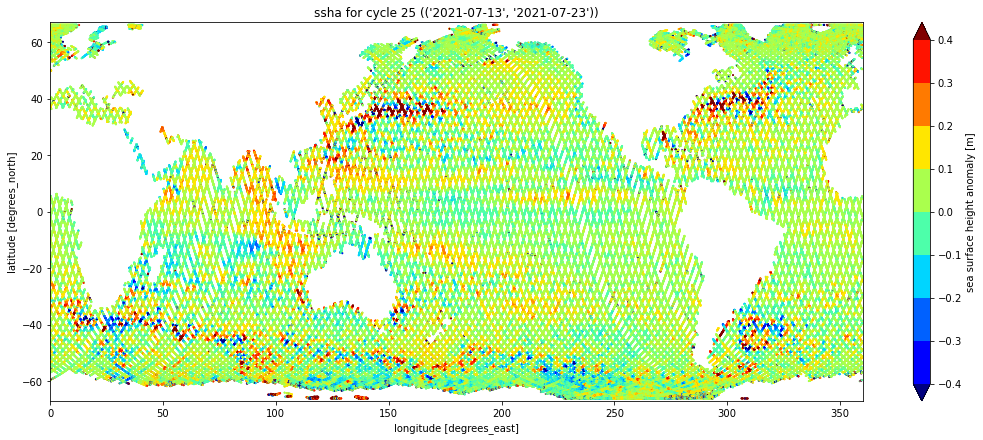

In [10]:
new_variable_names = list(map(lambda x: x.split("_")[-1], variables))
map_variable_names = dict(zip(variables, new_variable_names))
ds = ds.rename(map_variable_names).set_coords(['time','longitude','latitude'])  # rename variables

timeframe = (str(ds.time.data[0]).split('T')[0],
             str(ds.time.data[-1]).split('T')[0])  # get timestamps tuple

ds.plot.scatter(y="latitude", x="longitude", hue="ssha", 
                vmin=-0.4, vmax=0.4, cmap="jet", levels=9, 
                aspect=2.5, size=6, s=1, )
plt.ylim(-67., 67.)
plt.xlim(0., 360.)
plt.tight_layout()
plt.title(f"ssha for cycle {cycle} ({timeframe})")

## Process

### 0.5-degree grid from ECCO V4r4 (int)

>*Acknowledgement: [*pyresample*](https://pyresample.readthedocs.io/en/latest/api/pyresample) approach shared by Ian Fenty, NASA JPL/ECCO.*

ECCO V4r4 products are distributed in two spatial formats. One set of collections provides the ocean state estimates on the native model grid (LLC0090) and the other provides them after interpolating to a regular grid defined in geographic coordinates with horizontal cell size of 0.5-degrees. The latitude/longitude grid is distributed as its own collection in one netcdf file: https://search.earthdata.nasa.gov/search/granules?p=C2013583732-POCLOUD

Download the ECCO grid geometry netcdf from its https download endpoint in NASA Earthdata Cloud. Open the file and print the header content for the `maskC` variable, which contains a boolean mask representing the wet/dry state of the area contained in each cell of a 3d grid with dimensions mapped to `Z`, `latitude`, and `longitude`.

In [11]:
ecco_file = download("https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/"
                     "ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc")

ecco_grid = xr.open_dataset(ecco_file).isel(Z=0)  # select 0 on z-axis

ecco_mask = ecco_grid.maskC

print(ecco_grid)

<xarray.Dataset>
Dimensions:         (latitude: 360, longitude: 720, nv: 2)
Coordinates:
    Z               float32 -5.0
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             float32 ...
    maskC           (latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Convention

### Get ssha variable on 0.5-degree grid

Resample *ssha* data using kd-tree gaussian weighting neighbour approach. Define a function that implements the following steps:

1. Generate two 2d arrays of lats/lons using the permuted 1d coordinates from an input gridded dataset.
2. Define the target grid geometry using the 2d arrays of lats/lons.
3. Define the source grid geometry using the 1d arrays of lats/lons from an input dataset.

In [12]:
import warnings

def l2alt2grid(source: xr.DataArray, target: xr.DataArray, **options):
    nans = ~np.isnan(source.values)
    data = source.values[nans]

    lats = source.latitude.values[nans]
    lons = (source.longitude.values[nans] + 180) % 360 - 180
    src = pr.SwathDefinition(lons, lats)

    lons1d = target.longitude.values
    lats1d = target.latitude.values
    lons2d, lats2d = np.meshgrid(lons1d, lats1d)
    tgt = pr.SwathDefinition(lons2d, lats2d)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        res, std, cnt = resample_gauss(src, data, tgt, **options)
    
    coords = {'latitude': lats1d, 'longitude': lons1d}
    return (xr.DataArray(res, coords=coords),
            xr.DataArray(std, coords=coords),
            xr.DataArray(cnt, coords=coords), )

Set the gridding parameters in the python dictionary below; then pass it to the function as the last of three required positional arguments (the first two are the source dataset and the dataset that provides the target grid geometry).

In [13]:
gridding_options = dict(
    radius_of_influence = 175000,  
    sigmas              = 25000,
    neighbours          = 100,
    fill_value          = np.nan,
    with_uncert         = True
)

result, stddev, counts = l2alt2grid(ds.ssha, ecco_mask, **gridding_options)

result.shape == (ecco_grid.latitude.size, 
                 ecco_grid.longitude.size)

True

### Plot gridded ssha, gridding statistics

Plot each array for the output 'grid' and the grid statistics 'stddev' and 'counts'.

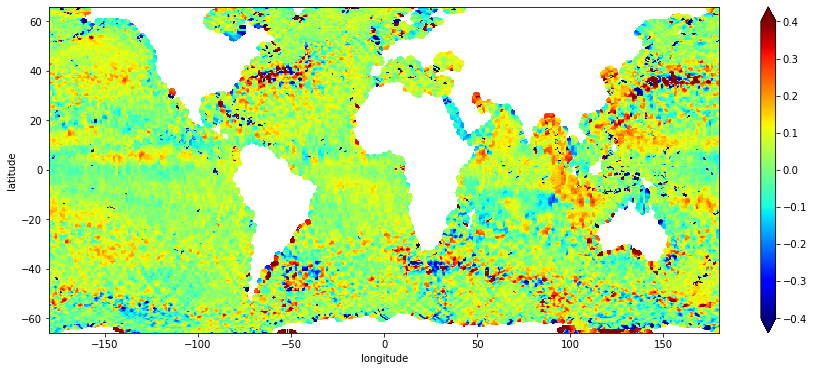

In [14]:
result.sel(latitude=slice(-66.,66.)).plot(cmap="jet", vmin=-0.4, vmax=0.4, figsize=(15,6))

Look at this plot and adjust gridding parameters as needed to refine ssha grid.

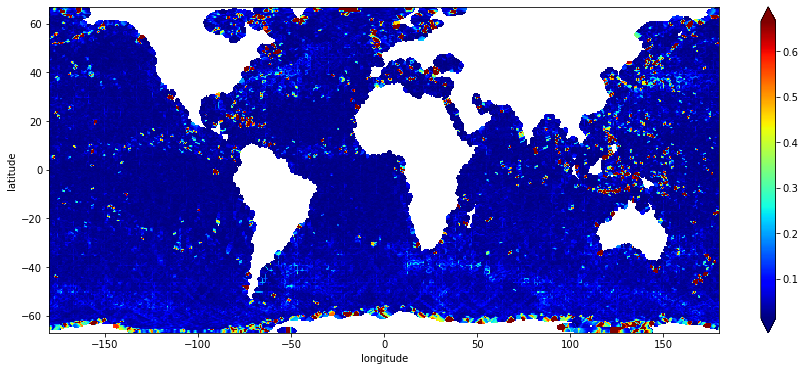

In [15]:
stddev.sel(latitude=slice(-67.,67.)).plot(cmap="jet", robust=True, figsize=(15,6))

a guess: the yellow areas with lower counts correspond to pass positions at the start/end of the cycle.

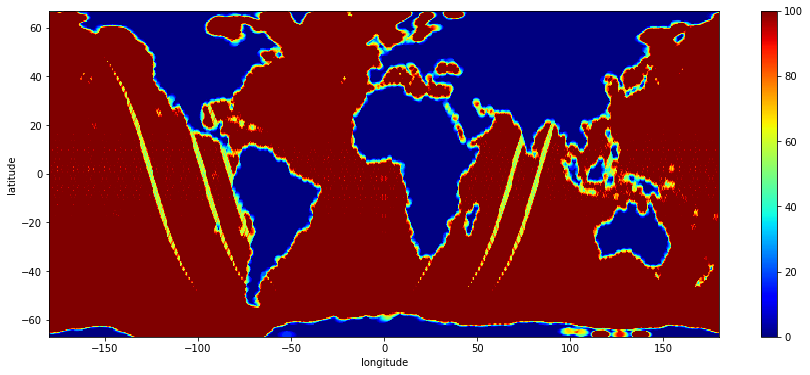

In [16]:
counts.sel(latitude=slice(-67.,67.)).plot(cmap="jet", robust=True, figsize=(15,6))

In [17]:
result.sel(latitude=slice(-66.,66.)).to_pandas().T.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,,,,,,,,
-65.75,304.0,0.209026,0.830608,-1.471174,-0.069080,0.039957,0.259600,6.104942
-65.25,316.0,0.216497,0.479879,-0.793696,0.002569,0.080189,0.301957,3.173239
-64.75,326.0,0.218253,0.465126,-0.593413,0.008729,0.085963,0.296550,2.885002
-64.25,332.0,0.090540,0.453919,-0.909328,-0.030323,0.040090,0.097437,2.914544
-63.75,371.0,0.029598,0.379806,-0.884937,-0.064511,0.001728,0.062316,2.879200
...,...,...,...,...,...,...,...,...
63.75,310.0,0.034539,0.133022,-0.580132,-0.010876,0.038027,0.081060,0.806144
64.25,314.0,0.018076,0.118825,-0.690086,-0.016610,0.036694,0.077421,0.286705
64.75,311.0,-0.085785,1.264886,-19.397700,-0.022718,0.041526,0.080252,1.397690


## Appendix

### Sentinel-6A MF

The Sentinel-6A Michael Freilich radar altimeter mission, or Sentinel-6, produces high-precision measurements of global sea-level. You can learn about the mission and ocean altimetry applications and datasets through the following links:

* https://www.nasa.gov/sentinel-6
* https://sealevel.jpl.nasa.gov/missions/jasoncs/
* https://sentinel-6.cnes.fr/en/JASON-CS/index.htm
* https://podaac.jpl.nasa.gov/Sentinel-6

### Ocean Surface Topography

The primary contribution of satellite altimetry to satellite oceanography has been to:

* Improve the knowledge of ocean tides and develop global tide models.
* Monitor the variation of global mean sea level and its relationship to changes in ocean mass and heat content.
* Map the general circulation variability of the ocean, including the ocean mesoscale, over decades and in near real-time using multi-satellite altimetric sampling.

![altimetry](https://podaac.jpl.nasa.gov/sites/default/files/content/PO.DAAC_SAT_Timeline_high_res.jpg)

The Surface Water Ocean Topography (SWOT) mission represents the next-generation of sea surface height observation. It will bring together oceanography and hydrology to focus on gaining a better understanding of the world's oceans and its terrestrial surface waters. U.S. and French oceanographers and hydrologists have joined forces to develop this new space mission to make the first global survey of Earth's surface water, observe the fine details of the ocean's surface topography and measure how water bodies change over time. The payload on SWOT will include a Jason-class radar altimeter that will serve to extend the time series of sea surface height data into the future, beyond the lifespan of Sentinel-6 MF, which is introduced immediately below. Read more about SWOT at: https://podaac.jpl.nasa.gov/SWOT/    

### Earthdata Cloud Services Overview

This workflow example downloads subsets of the netcdf datasets via OPeNDAP for massive efficiency gains (network/compute).

**Access for direct download:**

* Browse and download granules through Earthdata Search -- https://search.earthdata.nasa.gov/search/granules?p=C1968980576-POCLOUD
* Browse and download granules from HTTPS endpoints -- https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1968980576-POCLOUD
* Browse and download granules from S3 endpoints (example forthcoming, assuming s3 direct access has been enabled for the collection)

**Access through data services:**

Data and metadata are also accessible in reduced forms through higher-level cloud data services, for example:

* https://harmony.earthdata.nasa.gov/ -- Data reduction via on-demand subsetting and other high-level reformatting
    * Interface to backend services such as data file format conversion, subsetting at L2+, regridding and reprojection at L3+, and more.
    * Compatibility depends on the data processing level and data/file format, and so their expected behavior vary also.
    * Services available through Harmony API reduce the technical burden on users by covering certain low-level data transformations that a user would normally have to apply themselves, even to simply subset a dataset from OPeNDAP.
* https://opendap.earthdata.nasa.gov/ -- Data reduction via basic subsetting along coordinate dimensions and by variable 
    * Requires more familiarity with the contents of the target dataset, as well knowledge of how to select for data along the dimensions which correspond to space/time coordinates fitting the geographic and temporal coverage of interest.
    * User Guide: https://opendap.github.io/documentation/UserGuideComprehensive.html

### Python API References

* *Bash*
    * https://www.gnu.org/software/coreutils/manual/html_node/du-invocation.html
* *Python*
    * https://docs.python.org/3/library/functions.html#map    
    * https://docs.python.org/3/library/functions.html#zip
    * https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor
* *numpy* (https://numpy.org/doc/stable/reference)    
    * [numpy.ndarray.data](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.data.html)      
    * [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)    
    * [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html)    
    * [datetimes](https://numpy.org/doc/stable/reference/arrays.datetime.html)    
    * [numpy.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)    
    * [numpy.nansum](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html)    
* *xarray* (https://xarray.pydata.org/en/stable)    
    * [xarray.DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)    
    * [xarray.DataArray.values](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html)    
    * [xarray.DataArray.mean](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html)    
    * [xarray.DataArray.isel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html)
    * [xarray.open_dataset](https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
    * [xarray.DataArray.plot](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html)
    * [xarray.Dataset.rename](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html)
* *pyresample*
    * [pyresample.geometry.SwathDefinition](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.geometry.SwathDefinition)
    * [pyresample.kd_tree.resample_gauss](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.kd_tree.resample_gauss)